In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from loader.data_loader import PMEmoDataset
import torch.utils.data as torchData
from model import spectroCnnVanilla
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error, r2_score
from tqdm import tqdm

In [2]:
# TODO normalize spectrograms
# TODO save model weights
# TODO split model into distinct valence and arousal models, because combining them into a single model might affect the other, causing the unstable r2 scores, losses, rsme values

In [3]:
root_dir = "dataset"
dataset = PMEmoDataset(root_dir)

In [4]:
# Train-test split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [5]:
print(f'Dataset size: {len(dataset)}')
print(f'Train dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')  # 767 613 154
print(f'Spectrogram: {dataset[0][0].shape}')
print(f'EDA: {dataset[0][1].shape}')
print(f'Arousal: {dataset[0][2].shape}')
print(f'Valence: {dataset[0][3].shape}')
print(f'Music vector: {dataset[0][4].shape}')

Dataset size: 7670
Train dataset size: 6136
Test dataset size: 1534
Spectrogram: torch.Size([1, 369, 496])
EDA: torch.Size([1, 896])
Arousal: torch.Size([1])
Valence: torch.Size([1])
Music vector: torch.Size([319])


In [6]:
print(dataset[0][0])

tensor([[[  0.,   0.,   0.,  ...,  16.,  32.,  31.],
         [  0.,   0.,   0.,  ...,  16.,  32.,  31.],
         [  0.,   3.,   0.,  ...,  38.,  47.,  50.],
         ...,
         [ 43.,  95., 105.,  ...,  76.,  66.,  72.],
         [ 43.,  95., 105.,  ...,  76.,  66.,  72.],
         [ 43.,  95., 105.,  ...,  76.,  66.,  72.]]])


In [7]:
batch_size = 16


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=8)

In [8]:
# Instantiate the model
usesSpectrogram = True
usesEDA = True
usesMusic = True
predictsArousal = True
predictsValence = True
usesMusicLSTM = False

# Ensure that predictArousal and predictValence are not both False
assert predictsArousal or predictsValence
# Ensure that at least one of usesSpectrogram, usesEDA, and usesMusic is True
assert usesSpectrogram or usesEDA or usesMusic

model = spectroCnnVanilla.SpectroNet(usesSpectrogram,
                                    usesEDA,
                                    usesMusic,
                                    predictsArousal,
                                    predictsValence,
                                    usesMusicLSTM)

In [9]:
print(model)

SpectroNet(
  (spec_cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): AdaptiveAvgPool2d(output_size=(1, 1))
    (13): Flatten(start_dim=1, end_dim=-1)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features

In [10]:
num_params = 0
for x in model.parameters():
  num_params += len(torch.flatten(x))

print(f'Number of parameters in the model: {num_params:,}')

Number of parameters in the model: 233,122


In [11]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# optimizer = optim.SGD(model.parameters(), lr=0.001)

# Training loop
num_epochs = 3
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

cuda


In [24]:
def memory_stats():
    print(torch.cuda.memory_allocated()/1024**2)
    print(torch.cuda.memory_reserved()/1024**2)

In [25]:
memory_stats()

31.0693359375
5162.0


In [26]:
# if device == 'cuda':
#     torch.cuda.empty_cache()

In [27]:
def unpack_data(data):
    spectrogram, eda_data, arousal_label, valence_label, music_vector = data
    spectrogram = spectrogram.to(device)
    eda_data = eda_data.to(device)
    arousal_label = arousal_label.to(device)
    valence_label = valence_label.to(device)
    music_vector = music_vector.to(device=device, dtype=torch.float32)
    return spectrogram, eda_data, arousal_label, valence_label, music_vector

In [28]:
# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    pbar_train = tqdm(enumerate(train_loader, 0), unit="batch", total=len(train_loader), desc=f'Train epoch {str(epoch + 1)}')
    for i, data in pbar_train:
        spectrogram, eda_data, arousal_label, valence_label, music_vector = unpack_data(data)

        optimizer.zero_grad()

        # # Print shapes of all inputs
        # print("--------------")
        # print(f"Spectrogram shape: {spectrogram.shape}")
        # print(f"EDA data shape: {eda_data.shape}")
        # print(f"Arousal label shape: {arousal_label.shape}")
        # print(f"Valence label shape: {valence_label.shape}")
        # print(f"Music vector shape: {music_vector.shape}")

        output = model(spectrogram, eda_data, music_vector)
        labels = torch.cat((arousal_label, valence_label), -1)

        # print(f'Output: {output.shape}')
        # print(f'Labels: {labels.shape}')
        
        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        pbar_train.set_postfix_str(f'Running loss: {running_loss / (i + 1)}')

    # Evaluate on the validation set
    model.eval()
    val_loss = 0.0
    arousal_preds = []
    valence_preds = []
    arousal_labels = []
    valence_labels = []

    with torch.no_grad():
        pbar_test = tqdm(enumerate(test_loader, 0), unit="batch", total=len(test_loader), desc=f'Validate epoch {str(epoch + 1)}')
        for i, data in pbar_test:
            spectrogram, eda_data, arousal_label, valence_label, music_vector = unpack_data(data)

            output = model(spectrogram, eda_data, music_vector)
            # print(output.shape)
            labels = torch.cat((arousal_label, valence_label), -1)
            val_loss = criterion(output, labels)
            arousal_output = output[:,0:1]
            valence_output = output[:,1:]
            arousal_preds.extend(arousal_output.cpu().numpy())
            valence_preds.extend(valence_output.cpu().numpy())
            arousal_labels.extend(arousal_label.cpu().numpy())
            valence_labels.extend(valence_label.cpu().numpy())

        # Calculate and print losses and metrics
        arousal_mse = root_mean_squared_error(arousal_labels, arousal_preds)
        valence_mse = root_mean_squared_error(valence_labels, valence_preds)
        arousal_r2 = r2_score(arousal_labels, arousal_preds)
        valence_r2 = r2_score(valence_labels, valence_preds)

        print(f"Epoch [{epoch + 1}/{num_epochs}], "
                f"Train Loss: {running_loss / len(train_loader):.4f}, "
                f"Val Loss: {val_loss / len(test_loader):.4f}, "
                f"Arousal RMSE: {arousal_mse:.4f}, "
                f"Valence RMSE: {valence_mse:.4f}, "
                f"Arousal R2: {arousal_r2:.4f}, "
                f"Valence R2: {valence_r2:.4f}")

print("Training finished.")

Validate epoch 1: 100%|██████████| 96/96 [00:04<00:00, 23.33batch/s]

Epoch [1/3], Train Loss: 0.0388, Val Loss: 0.0002, Arousal RMSE: 0.1981, Valence RMSE: 0.2083, Arousal R2: 0.3069, Valence R2: 0.2435



Validate epoch 2: 100%|██████████| 96/96 [00:04<00:00, 23.55batch/s]

Epoch [2/3], Train Loss: 0.0384, Val Loss: 0.0003, Arousal RMSE: 0.1944, Valence RMSE: 0.2153, Arousal R2: 0.3326, Valence R2: 0.1922



Validate epoch 3: 100%|██████████| 96/96 [00:04<00:00, 23.30batch/s]

Epoch [3/3], Train Loss: 0.0379, Val Loss: 0.0003, Arousal RMSE: 0.1984, Valence RMSE: 0.2039, Arousal R2: 0.3050, Valence R2: 0.2751
Training finished.


In [29]:
import time

t = time.localtime()
current_time = time.strftime("%y-%m-%d-%H%M", t)

PATH = './weights/spectroCnnVanilla-'+current_time+'.pt'
torch.save(model.state_dict(), PATH)
print(f'Model weights saved to: {PATH}')

Model weights saved to: ./weights/spectroCnnVanilla-24-04-15-2327.pt


Validate epoch 3:   0%|          | 0/96 [00:00<?, ?batch/s]

tensor([[0.7792, 0.7200],
        [0.7519, 0.5550],
        [0.4594, 0.3992],
        [0.4240, 0.3996],
        [0.5784, 0.5206],
        [0.5798, 0.5611],
        [0.6537, 0.6022],
        [0.4993, 0.4615],
        [0.4272, 0.3848],
        [0.4642, 0.4486],
        [0.7218, 0.6360],
        [0.5926, 0.4925],
        [0.6584, 0.6110],
        [0.6414, 0.7035],
        [0.6535, 0.6232],
        [0.7218, 0.5208]], device='cuda:0')


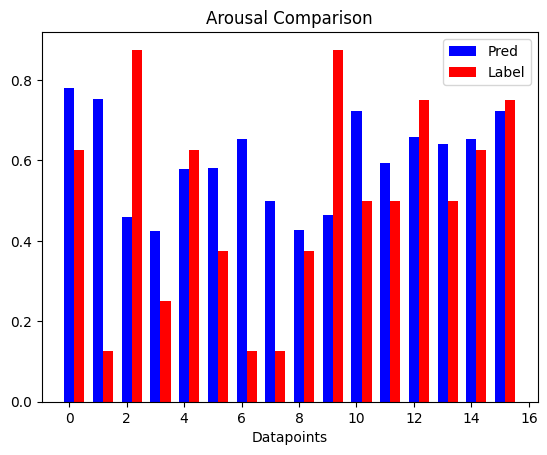

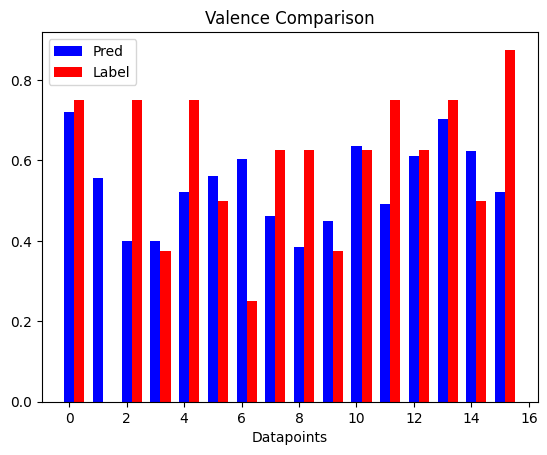

Validate epoch 3:   0%|          | 0/96 [00:00<?, ?batch/s]


In [30]:
import matplotlib.pyplot as plt
import numpy as np

with torch.no_grad():
    pbar_test = tqdm(enumerate(test_loader, 0), unit="batch", total=len(test_loader), desc=f'Validate epoch {str(epoch + 1)}')
    for i, data in pbar_test:
        spectrogram, eda_data, arousal_label, valence_label, music_vector = unpack_data(data)

        output = model(spectrogram, eda_data, music_vector)
        print(output)
        arousal_output = output[:,0:1]
        valence_output = output[:,1:]
        outputs = torch.cat((arousal_output, valence_output), -1)
        labels = torch.cat((arousal_label, valence_label), -1)
        # print(outputs)
        # print(labels)
    
        t = list(outputs.T[0].cpu())
        t_2 = list(labels.T[0].cpu())

        n=batch_size
        r = np.arange(n) 
        width = 0.35
        
        plt.bar(r, t, color = 'b', 
                width = width,
                label='Pred') 
        plt.bar(r + width, t_2, color = 'r', 
                width = width,
                label='Label')

        plt.xlabel('Datapoints')
        plt.title('Arousal Comparison')
        plt.legend()
        plt.show()


        t = list(outputs.T[1].cpu())
        t_2 = list(labels.T[1].cpu())

        n=16
        r = np.arange(n) 
        width = 0.35
        
        plt.bar(r, t, color = 'b', 
                width = width,
                label='Pred') 
        plt.bar(r + width, t_2, color = 'r', 
                width = width,
                label='Label')

        plt.xlabel('Datapoints')
        plt.title('Valence Comparison')
        plt.legend()
        plt.show()
        break

In [31]:
# with torch.no_grad():
#     pbar_test = tqdm(enumerate(test_loader, 0), unit="batch", total=len(test_loader), desc=f'Validate epoch {str(epoch + 1)}')
#     for i, data in pbar_test:
#         spectrogram, eda_data, arousal_label, valence_label, music_vector = unpack_data(data)

#         output = model(spectrogram, eda_data, music_vector)
#         arousal_output = output[:,0:1]
#         valence_output = output[:,1:]
#         outputs = torch.cat((arousal_output, valence_output), -1)
#         labels = torch.cat((arousal_label, valence_label), -1)
#         print(arousal_output, valence_output)
#         print(labels)
#         break

# import torch
# import matplotlib.pyplot as plt

# t = torch.tensor([0., 0., 1., 1., 0., 1., 1., 0., 0., 0.])
# hist = torch.histc(t, bins = 2, min = 0, max = 1)

# bins = 2
# x = range(bins)
# plt.bar(x, hist, align='center')
# plt.xlabel('Bins')